source: https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [1]:
import torch
import os
import random
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import albumentations as A
import xml.etree.ElementTree as ET
import lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import VOCDetection
from torchvision import models
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

In [3]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, feature_extraction=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        if feature_extraction:
            return out  # Return features from layer4
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# prepare data modules
class PASCALDataset(Dataset):
    
    def __init__(
        self, 
        root_dir: str, 
        split: str = 'train',
        year: str = '2012',
        transform = None
    ) -> Dataset:
        
        super().__init__()
        self.split = split
        self.year = year
        self.transform = transform
        self.num_classes = 20
        
        # directory of images and labels
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'JPEGImages')
        self.labels_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC' + year, 'Annotations')
        
        # splits directory
        self.splits_dir = os.path.join(self.root_dir, 'VOCdevkit', 'VOC' + year, 'ImageSets', 'Main')
        
        # load splits
        self.img_ids = []
        self.images = []
        self.labels = []
        self.load_data()
        print('Loaded {} images and {} labels'.format(len(self.images), len(self.labels)))
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        
        # load image
        image = cv2.imread(self.images[idx], cv2.COLOR_BGR2RGB)
        
        # load xml label as dictionary
        label_path = self.labels[idx]
        boxes, labels = self.parse_voc_xml(label_path)
        
        # add transform
        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            boxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
            labels = torch.tensor(augmented['labels'], dtype=torch.long)
        
        return image, {'boxes': boxes, 'labels': labels}
    
    def load_data(self):
        
        with open(os.path.join(self.splits_dir, self.split + '.txt')) as f:
            for line in f:
                self.img_ids.append(line.strip())
                
        for img_id in self.img_ids:
            img_file = os.path.join(self.img_dir, img_id + '.jpg')
            ann_file = os.path.join(self.labels_dir, img_id + '.xml')
            self.images.append(img_file)
            self.labels.append(ann_file)
            
        assert len(self.images) == len(self.labels)
        
    def parse_voc_xml(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            box = [
                int(bbox.find('xmin').text),
                int(bbox.find('ymin').text),
                int(bbox.find('xmax').text),
                int(bbox.find('ymax').text)
            ]
            boxes.append(box)
            labels.append(label)  # Labels are still strings here

        # Convert labels to integers
        label_map = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
                     'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10,
                     'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
                     'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
        labels = [label_map[label] for label in labels]
        
        return boxes, labels
    
### PASCAL VOC DATAMODULE ###
class PASCALDataModule(pl.LightningDataModule):
    
    def __init__(
        self, 
        root_dir: str, 
        train_dataset: Dataset,
        test_dataset: Dataset,
        batch_size: int = 32, 
        num_workers: int = 4, 
        image_size: int = 512
    ) -> pl.LightningDataModule:
        """Data Module for handling PASCAL VOC 2012 dataset.

        Args:
            root_dir (str): Root directory of the PASCAL VOC dataset.
            batch_size (int, optional): Number of samples per batch. Defaults to 32.
            train_dataset (Dataset): Training dataset.
            test_dataset (Dataset): Testing dataset.
            batch_size (int, optional): Number of samples per batch. Defaults to 32.
            num_workers (int, optional): Number of workers to use for data loading. Defaults to 4.
            image_size (int, optional): Size of the image to use. Defaults to 512.
        """
        
        super().__init__()
        self.save_hyperparameters(ignore=["train_dataset", "test_dataset"])
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        
        self.train_transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
        self.test_transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    def prepare_data(self):
        # Download the Pascal VOC dataset
        VOCDetection(self.root_dir, year='2012', image_set='train', download=False)
        VOCDetection(self.root_dir, year='2012', image_set='val', download=False)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            print("Setting up training datasets")
            if self.train_dataset is None:
                self.train_dataset = PASCALDataset(self.root_dir, split='train', transform=self.train_transform)
        
        if stage == 'test' or stage is None:
            if self.test_dataset is None:
                self.test_dataset = PASCALDataset(self.root_dir, split='val', transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

    @staticmethod
    def collate_fn(batch):
        images, targets = zip(*batch)
        images = torch.stack(images)
        boxes = [target['boxes'] for target in targets]
        labels = [target['labels'] for target in targets]
        return images, {'boxes': boxes, 'labels': labels}

In [5]:
# load dataset
image_size = 512
root_dir = '/data2/eranario/data/PASCAL-VOC-2012'
transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
dataset = PASCALDataset(root_dir=root_dir, split='train', transform=transform)

# get portion of the dataset
# total_samples = len(dataset)
# subset_indices = random.sample(range(total_samples), total_samples // 10)
# subset_dataset = torch.utils.data.Subset(dataset, subset_indices)
subset_loader = DataLoader(dataset, batch_size=12, shuffle=False, num_workers=4, collate_fn=PASCALDataModule.collate_fn)
# print("Subset dataset has {} samples".format(len(subset_dataset)))

Loaded 5717 images and 5717 labels


In [6]:
# extract features
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", 
    "bus", "car", "cat", "chair", "cow", 
    "diningtable", "dog", "horse", "motorbike", "person", 
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def load_pretrained_resnet50(num_classes=10):
    pretrained_resnet = models.resnet50(pretrained=True)
    custom_resnet = ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

    # Copy pretrained weights to custom model
    pretrained_dict = pretrained_resnet.state_dict()
    custom_dict = custom_resnet.state_dict()

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in custom_dict and v.size() == custom_dict[k].size()}
    custom_dict.update(pretrained_dict)

    # Load the state dict into the custom model
    custom_resnet.load_state_dict(custom_dict)

    return custom_resnet

num_classes = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_pretrained_resnet50(num_classes)
model = model.to(device)

class_to_index = {class_name: idx for idx, class_name in enumerate(VOC_CLASSES)}

features = []
with torch.no_grad():
    for images, targets in subset_loader:
        images = images.cuda()  # If using GPU
        out = model(images, feature_extraction=True)  # Extract features after the third layer
        features.append(out.cpu().numpy())

features = np.concatenate(features, axis=0)

/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [7]:
features.shape

(5717, 2048, 16, 16)

In [8]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

features_flattened = features.reshape(features.shape[0], -1)

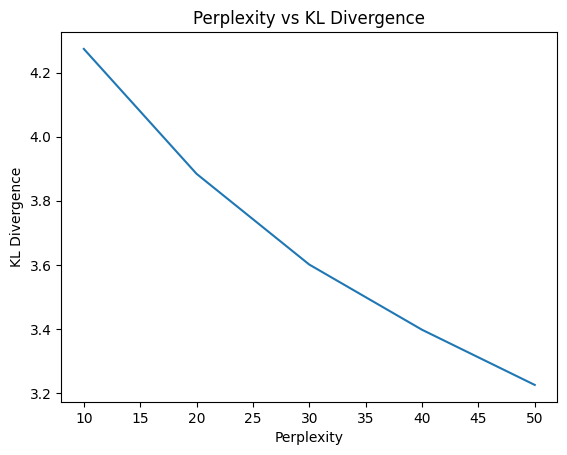

In [11]:
# find optimal perplexity
perplexity = [10, 20, 30, 40, 50]
divergence = []

for i in perplexity:
    tsne = TSNE(n_components=2, perplexity=i, init='pca')
    tsne_result = tsne.fit_transform(features_flattened)
    divergence.append(tsne.kl_divergence_)
    
# plot divergence (y) vs perplexity (x)
plt.plot(perplexity, divergence)
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.title('Perplexity vs KL Divergence')
plt.show()

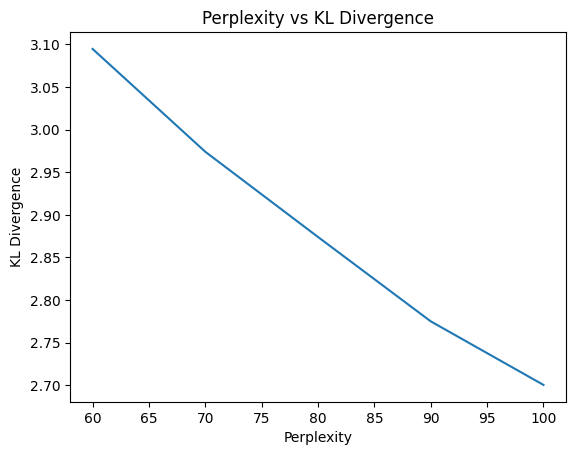

In [12]:
perplexity = [60, 70, 80, 90, 100]
divergence = []

for i in perplexity:
    tsne = TSNE(n_components=2, perplexity=i, init='pca')
    tsne_result = tsne.fit_transform(features_flattened)
    divergence.append(tsne.kl_divergence_)
    
# plot divergence (y) vs perplexity (x)
plt.plot(perplexity, divergence)
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.title('Perplexity vs KL Divergence')
plt.show()

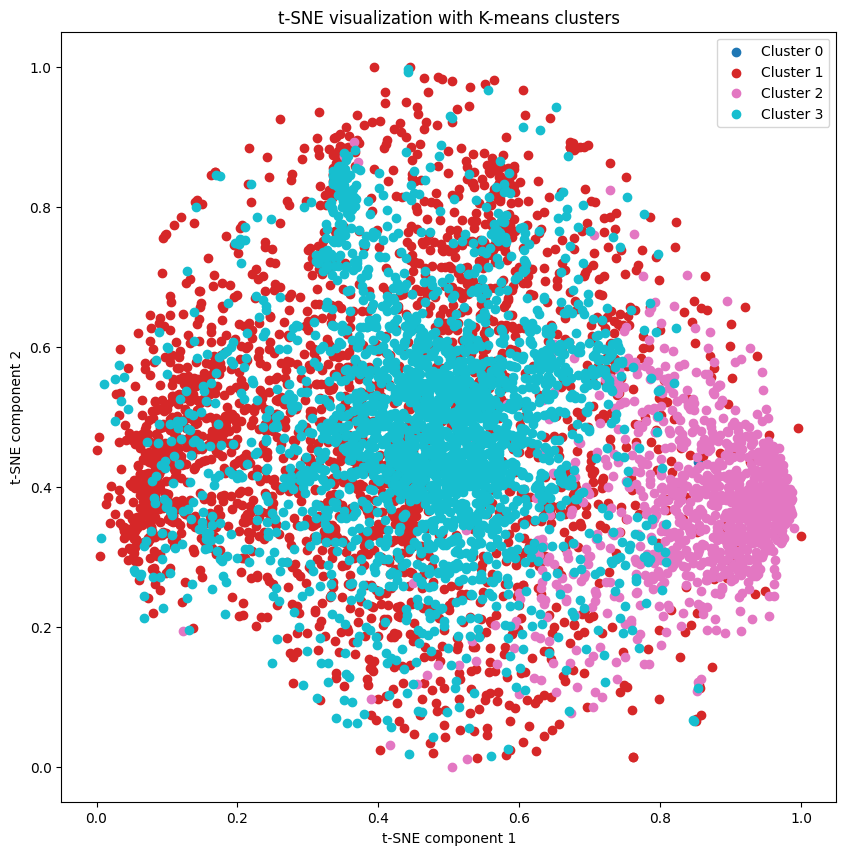

In [10]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_flattened)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, init='pca')
features_tsne = tsne.fit_transform(features_flattened)

# Scale t-SNE results to [0, 1] range
tx = scale_to_01_range(features_tsne[:, 0])
ty = scale_to_01_range(features_tsne[:, 1])

# Generate a colormap
cmap = plt.get_cmap('tab10', num_clusters)

# Plot t-SNE results with color coding based on clusters
plt.figure(figsize=(10, 10))
for cluster in range(num_clusters):
    indices = np.where(cluster_labels == cluster)
    plt.scatter(tx[indices], ty[indices], label=f'Cluster {cluster}', color=cmap(cluster))

plt.legend()
plt.title('t-SNE visualization with K-means clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()